In [19]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [3]:
 #Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
detail_incident_activity = pd.read_csv('https://data.4tu.nl/file/657fb1d6-b4c2-4adc-ba48-ed25bf313025/bd6cfa31-44f8-4542-9bad-f1f70c894728', sep=';')
#detail_incident = pd.read_csv('https://data.4tu.nl/file/a752c1b5-9732-4bbc-8949-bf24581f9034/740deeae-5014-48bf-8c86-4a4c3e0355a9', sep=';')
#detail_interaction = pd.read_csv('https://data.4tu.nl/file/f1f0a188-f31a-45af-a7c8-29727b318adf/e5872002-415b-4a37-9377-c82cccae902d', sep=';')
#detail_change = pd.read_csv('https://data.4tu.nl/file/e9c00fe9-c87a-450e-8bd6-d5e06a6b309a/9d7cd406-9826-4adf-8418-c751b475f556', sep=';')
detail_incident_activity.head(10)


,Incident ID,DateStamp,IncidentActivity_Number,IncidentActivity_Type,Assignment Group,KM number,Interaction ID
0,IM0000004,07-01-2013 08:17:17,001A3689763,Reassignment,TEAM0001,KM0000553,SD0000007
1,IM0000004,04-11-2013 13:41:30,001A5852941,Reassignment,TEAM0002,KM0000553,SD0000007
2,IM0000004,04-11-2013 13:41:30,001A5852943,Update from customer,TEAM0002,KM0000553,SD0000007
3,IM0000004,04-11-2013 12:09:37,001A5849980,Operator Update,TEAM0003,KM0000553,SD0000007
4,IM0000004,04-11-2013 12:09:37,001A5849979,Assignment,TEAM0003,KM0000553,SD0000007
5,IM0000004,04-11-2013 13:41:30,001A5852942,Assignment,TEAM0002,KM0000553,SD0000007
6,IM0000004,04-11-2013 13:51:18,001A5852172,Closed,TEAM0003,KM0000553,SD0000007
7,IM0000004,04-11-2013 13:51:18,001A5852173,Caused By CI,TEAM0003,KM0000553,SD0000007
8,IM0000004,04-11-2013 12:09:37,001A5849978,Reassignment,TEAM0003,KM0000553,SD0000007
9,IM0000004,25-09-2013 08:27:40,001A5544096,Operator Update,TEAM0003,KM0000553,SD0000007


In [ ]:
detail_incident_activity.columns

Index(['Incident ID', 'DateStamp', 'IncidentActivity_Number',
       'IncidentActivity_Type', 'Assignment Group', 'KM number',
       'Interaction ID'],
      dtype='object')

In [4]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas

detail_incident_activity['DateStamp'] = pd.to_datetime(detail_incident_activity['DateStamp'])

#detail_incident_activity.info()

In [5]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = detail_incident_activity.pivot_table(index='Incident ID', aggfunc={'DateStamp': ['min', 'max']}) 


case_starts_ends.head(2)

DateStamp                    
                            max                 min
Incident ID                                        
IM0000004   2013-09-25 08:27:40 2013-04-11 12:09:37
IM0000005   2013-12-04 11:03:27 2013-02-12 11:48:23

In [6]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['Incident ID', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
detail_incident_activity = detail_incident_activity.merge(case_starts_ends, on='Incident ID') 

detail_incident_activity['casestart'] = pd.to_datetime(detail_incident_activity['casestart'])

# Calculate the relative time by subtracting the process start time from the event timestamp
detail_incident_activity['relativetime'] = detail_incident_activity['DateStamp'] - detail_incident_activity['casestart']

detail_incident_activity['relativetime_s'] = detail_incident_activity['relativetime'].dt.seconds + 86400*detail_incident_activity['relativetime'].dt.days 

detail_incident_activity['relativedays'] = detail_incident_activity['relativetime'].dt.days

detail_incident_activity['caselength'] = detail_incident_activity['caseend'] - detail_incident_activity['casestart']
detail_incident_activity.head(6)

,Incident ID,DateStamp,IncidentActivity_Number,IncidentActivity_Type,Assignment Group,KM number,Interaction ID,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,IM0000004,2013-07-01 08:17:17,001A3689763,Reassignment,TEAM0001,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,80 days 20:07:40,6984460,80,166 days 20:18:03
1,IM0000004,2013-04-11 13:41:30,001A5852941,Reassignment,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
2,IM0000004,2013-04-11 13:41:30,001A5852943,Update from customer,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
3,IM0000004,2013-04-11 12:09:37,001A5849980,Operator Update,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
4,IM0000004,2013-04-11 12:09:37,001A5849979,Assignment,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
5,IM0000004,2013-04-11 13:41:30,001A5852942,Assignment,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03


In [7]:
# Переименуем колонки в соответсвии с требованиями Process mining
detail_incident_activity.rename(columns=
                {'DateStamp': 'time:timestamp',
                 'Incident ID': 'case:concept:name',
                 'IncidentActivity_Type': 'concept:name',
                 'Assignment Group': 'org:resource'},
                inplace=True)

detail_incident_activity

,case:concept:name,time:timestamp,IncidentActivity_Number,concept:name,org:resource,KM number,Interaction ID,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,IM0000004,2013-07-01 08:17:17,001A3689763,Reassignment,TEAM0001,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,80 days 20:07:40,6984460,80,166 days 20:18:03
1,IM0000004,2013-04-11 13:41:30,001A5852941,Reassignment,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
2,IM0000004,2013-04-11 13:41:30,001A5852943,Update from customer,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
3,IM0000004,2013-04-11 12:09:37,001A5849980,Operator Update,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
4,IM0000004,2013-04-11 12:09:37,001A5849979,Assignment,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
466732,IM0047056,2014-03-31 15:42:37,001A6917801,Closed,TEAM0191,KM0001287,SD0146986,2014-03-31 15:42:37,2014-03-31 15:35:36,0 days 00:07:01,421,0,0 days 00:07:01
466733,IM0047057,2014-03-31 17:24:50,001A6919138,Open,TEAM0199,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 00:00:00,0,0,0 days 05:22:43
466734,IM0047057,2014-03-31 17:25:07,001A6919139,Update,TEAM0199,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 00:00:17,17,0,0 days 05:22:43
466735,IM0047057,2014-03-31 22:47:33,001A6922086,Closed,TEAM0134,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 05:22:43,19363,0,0 days 05:22:43


In [8]:
# Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(detail_incident_activity)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [ ]:
detail_incident_activity.shape

(466737, 13)

In [ ]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

46616

In [ ]:
#всего инцидентов

len(detail_incident_activity['case:concept:name'].unique())


46616

In [9]:
import datetime

# Сделаем 'Closed' последним действием в цепочке
detail_incident_activity.loc[detail_incident_activity['concept:name'] == 'Closed', 'time:timestamp'] += pd.Timedelta(seconds=1)

In [10]:
# Для сбора объективной статистики уберем все цепочки, у которых нет события 'Closed'

ci = detail_incident_activity[detail_incident_activity['concept:name'] == 'Closed']['case:concept:name'].unique()
detail_incident_activity = detail_incident_activity[detail_incident_activity['case:concept:name'].isin(ci)]

In [11]:
from pm4py.algo.filtering.log.attributes import attributes_filter
#посмотрим частотные признаки по командам
activities = attributes_filter.get_attribute_values(detail_incident_activity, "org:resource")
activities

{'TEAM0001': 3777,
 'TEAM0002': 6694,
 'TEAM0003': 10047,
 'TEAM9999': 8246,
 'TEAM0004': 1002,
 'TEAM0005': 115,
 'TEAM0171': 5260,
 'TEAM0006': 2,
 'TEAM0007': 15864,
 'TEAM0008': 81584,
 'TEAM0009': 152,
 'TEAM0010': 5043,
 'TEAM0011': 77,
 'TEAM0012': 68,
 'TEAM0013': 4490,
 'TEAM0014': 6414,
 'TEAM0015': 11964,
 'TEAM0016': 9096,
 'TEAM0017': 6643,
 'TEAM0018': 17368,
 'TEAM0019': 2965,
 'TEAM0020': 1133,
 'TEAM0021': 2652,
 'TEAM0022': 65,
 'TEAM0023': 15190,
 'TEAM0172': 784,
 'TEAM0024': 1312,
 'TEAM0025': 1803,
 'TEAM0026': 4,
 'TEAM0027': 1392,
 'TEAM0028': 1365,
 'TEAM0029': 383,
 'TEAM0030': 47,
 'TEAM0031': 16414,
 'TEAM0032': 385,
 'TEAM0033': 2248,
 'TEAM0034': 2841,
 'TEAM0035': 1768,
 'TEAM0036': 198,
 'TEAM0037': 634,
 'TEAM0038': 851,
 'TEAM0039': 19199,
 'TEAM0040': 2878,
 'TEAM0041': 1615,
 'TEAM0059': 724,
 'TEAM0173': 1162,
 'TEAM0042': 1454,
 'TEAM0043': 694,
 'TEAM0044': 4830,
 'TEAM0045': 3311,
 'TEAM0046': 1323,
 'TEAM0047': 875,
 'TEAM0058': 1087,
 'TEAM0048

In [ ]:
from pm4py.algo.filtering.log.attributes import attributes_filter
#посмотрим частотные признаки по типам событий
activities = attributes_filter.get_attribute_values(detail_incident_activity, 'concept:name')
activities

{'Reassignment': 51870,
 'Update from customer': 3900,
 'Operator Update': 56149,
 'Assignment': 88247,
 'Closed': 50145,
 'Caused By CI': 34382,
 'Update': 35945,
 'Status Change': 50322,
 'Description Update': 4470,
 'Analysis/Research': 981,
 'Resolved': 1626,
 'Reopen': 2428,
 'OO Response': 33,
 'Communication with customer': 6142,
 'External Vendor Assignment': 3842,
 'Pending vendor': 3842,
 'Open': 46158,
 'Communication with vendor': 1737,
 'Vendor Reference': 656,
 'Urgency Change': 1310,
 'Impact Change': 1276,
 'Quality Indicator Fixed': 7791,
 'Problem Workaround': 140,
 'Problem Closure': 40,
 'Service Change': 159,
 'Affected CI Change': 184,
 'Referred': 29,
 'Vendor Reference Change': 128,
 'Incident reproduction': 23,
 'Quality Indicator': 2465,
 'Notify By Change': 281,
 'Contact Change': 32,
 'Mail to Customer': 3788,
 'Quality Indicator Set': 1956,
 'Callback Request': 53,
 'External update': 1099,
 'External Vendor Reassignment': 33,
 'alert stage 1': 113,
 'Dial-

In [12]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(detail_incident_activity)

variants_count

У нас есть: 31725 различных вариантов путей в нашем журнале событий


[{'variant': ('Open', 'Closed', 'Caused By CI'), 'count': 716},
 {'variant': ('Closed', 'Caused By CI', 'Open'), 'count': 681},
 {'variant': ('Caused By CI', 'Closed', 'Open'), 'count': 675},
 {'variant': ('Open', 'Caused By CI', 'Closed'), 'count': 647},
 {'variant': ('Caused By CI', 'Open', 'Closed'), 'count': 352},
 {'variant': ('Closed', 'Open', 'Caused By CI'), 'count': 323},
 {'variant': ('Caused By CI', 'Closed', 'Assignment', 'Open'), 'count': 147},
 {'variant': ('Closed', 'Caused By CI', 'Assignment', 'Open'), 'count': 138},
 {'variant': ('Open', 'Assignment', 'Caused By CI', 'Closed'), 'count': 130},
 {'variant': ('Closed', 'Caused By CI', 'Open', 'Assignment'), 'count': 128},
 {'variant': ('Open', 'Assignment', 'Closed', 'Caused By CI'), 'count': 125},
 {'variant': ('Open', 'Caused By CI', 'Closed', 'Assignment'), 'count': 124},
 {'variant': ('Assignment', 'Closed', 'Caused By CI', 'Open'), 'count': 121},
 {'variant': ('Caused By CI', 'Closed', 'Open', 'Assignment'), 'count'

 **Изучение журнала событий**

In [ ]:
#минимальное и максимальное количество событий в одном случае
print(f"Минимальное количество событий: {min(detail_incident_activity.groupby('case:concept:name').count()['concept:name'])}", f"Максимальное количество событий: {max(detail_incident_activity.groupby('case:concept:name').count()['concept:name'])} ",sep = '\n')


Минимальное количество событий: 1
Максимальное количество событий: 178 


In [ ]:
#Какая команда тратила меньше всего времени, а какая больше?
patient_times = detail_incident_activity.groupby('case:concept:name')['caselength'].sum()
patient_with_max_time = patient_times.idxmax()
patient_with_min_time = patient_times.idxmin()
print('Потративший больше всего времени:', patient_with_max_time)
print('Длительность:', patient_times.loc[patient_with_max_time])
print('Потративший меньше всего времени:', patient_with_min_time)
print('Длительность:', patient_times.loc[patient_with_min_time])

Потративший больше всего времени: IM0005897
Длительность: 103626 days 03:37:45
Потративший меньше всего времени: IM0000006
Длительность: 0 days 00:00:00


In [ ]:
#Какое событие является наиболее ресурсоёмким в данном журнале событий?
grouped_act = detail_incident_activity.groupby('concept:name').agg({'caselength': 'sum'})
grouped_act

In [ ]:
#Есть ли команды, которые перегружены работой?
# по количеству событий
resource_counts = detail_incident_activity.groupby('org:resource')['concept:name'].count().reset_index(name='count')
sorted_resource_counts = resource_counts.sort_values(by='count', ascending=False)

sorted_resource_counts

,org:resource,count
7,TEAM0008,81584
38,TEAM0039,19199
17,TEAM0018,17368
30,TEAM0031,16414
6,TEAM0007,15864
...,...,...
160,TEAM0161,2
237,TEAM0238,1
168,TEAM0169,1
163,TEAM0164,1


In [13]:
import numpy as np

#Какие события связаны с узкими местами и какие ресурсы задействованы? 
pd.pivot_table(detail_incident_activity,
               index=["concept:name", "org:resource"],
               values=["relativetime"],
               aggfunc=np.mean)

relativetime
concept:name            org:resource                            
Affected CI Change      TEAM9999      43 days 11:10:13.445652174
Analysis/Research       TEAM0001      78 days 15:33:08.272727273
                        TEAM0002        224 days 00:35:55.500000
                        TEAM0003     112 days 13:12:30.419689120
                        TEAM0004        128 days 23:50:21.750000
...                                                          ...
Vendor Reference Change TEAM0188       3 days 12:28:07.777777777
                        TEAM0190       1 days 00:45:36.333333333
                        TEAM0211                 0 days 00:00:00
                        TEAM9999               183 days 18:32:12
alert stage 1           TEAM9999     297 days 09:14:40.663716816

[2920 rows x 1 columns]

построим модели

replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]

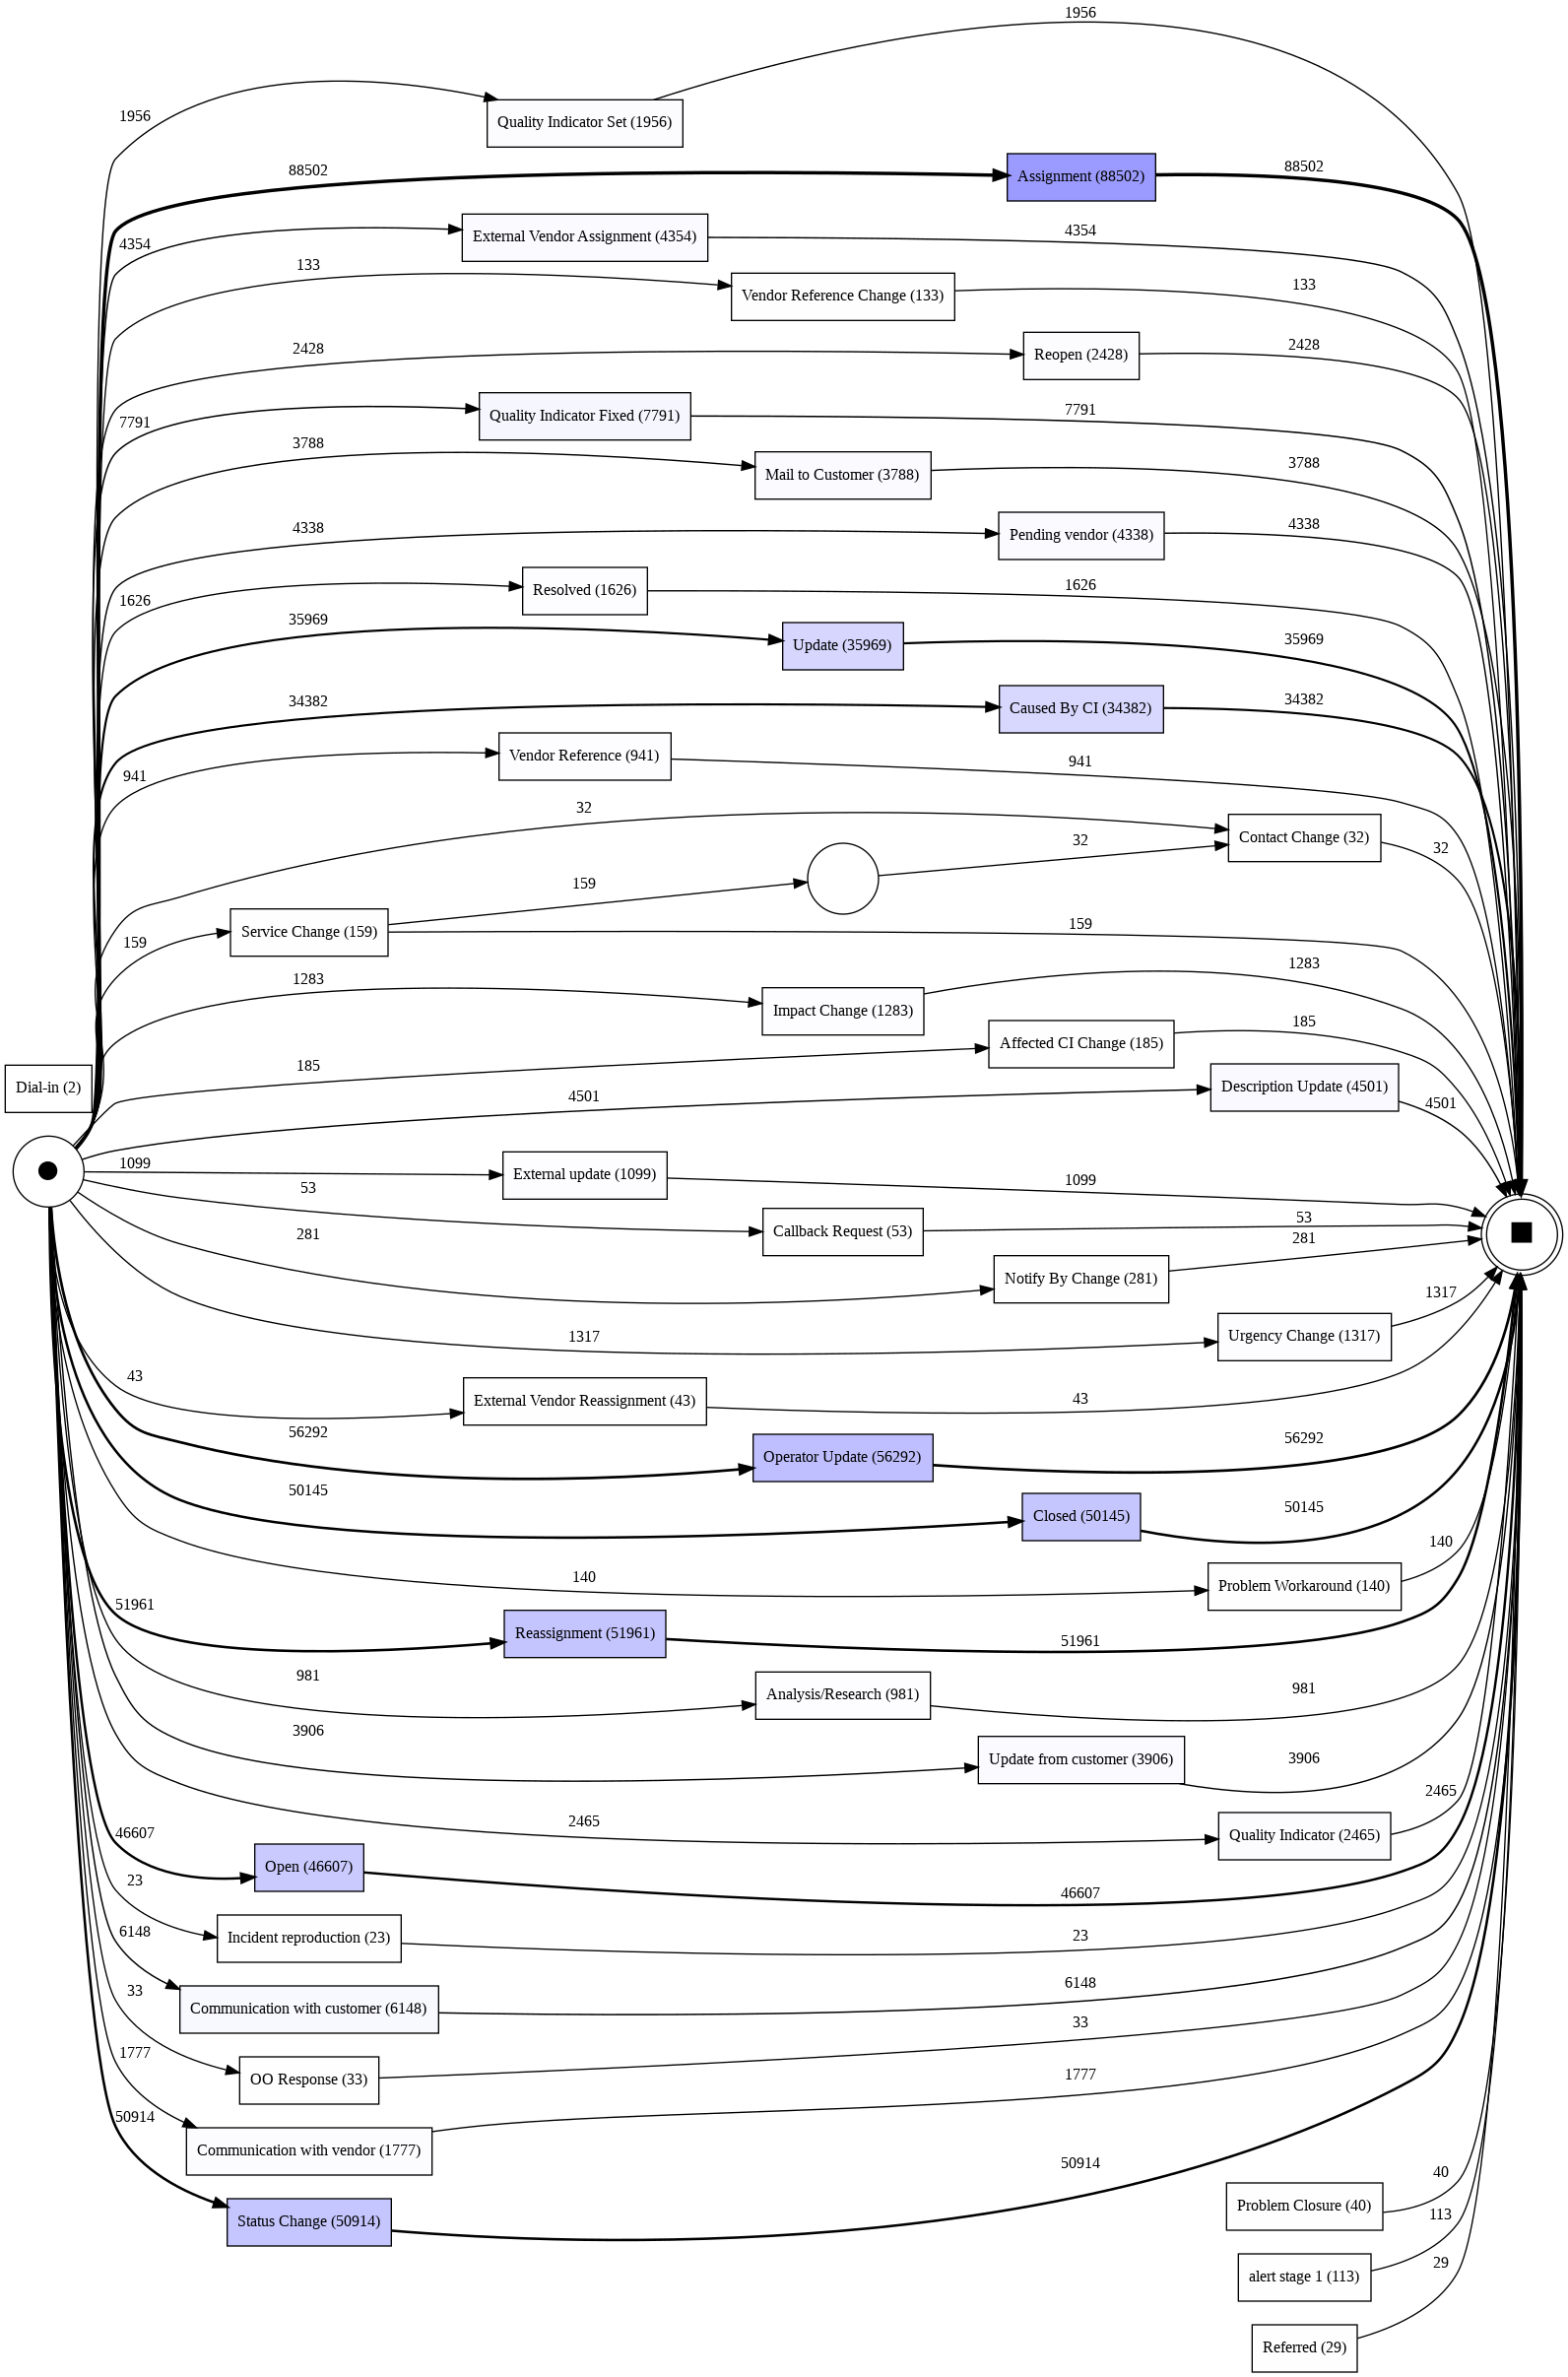

In [15]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [22]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer

In [ ]:
#alpha_miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

net2, initial_marking2, final_marking2 = alpha_miner.apply(event_log)

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simplicity2 = simplicity_evaluator.apply(net2)
print(f"Простота равна: {simplicity2}\n")

fitness2 = replay_fitness_evaluator.apply(
    event_log, 
    net2, 
    initial_marking2, 
    final_marking2, 
    variant=replay_fitness_evaluator.Variants.TOKEN_BASED,
)
print(f"Пригодность воспроизведения, используя метод на основе токенов, равна {fitness2}\n")

Простота равна: 0.38888888888888884



replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]

Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 0.0021451862021623475, 'average_trace_fitness': 0.25716339581514935, 'log_fitness': 0.18161879719803892, 'percentage_of_fitting_traces': 0.0021451862021623475}



In [ ]:
prec = precision_evaluator.apply(
    event_log, 
    net2, 
    initial_marking2, 
    final_marking2, 
    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,
)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")

gen = generalization_evaluator.apply(
    event_log, 
    net2, initial_marking2, 
    final_marking2,
)
print(f"\nОбобщение равно {gen}\n")

replaying log with TBR, completed variants ::   0%|          | 0/248024 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.8291706587621474



replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]


Обобщение равно 0.9287848614495434



In [ ]:
#dfg_graph
from pm4py.algo.discovery.dfg import algorithm as dfg_graph
from pm4py.objects.conversion.dfg import converter as dfg_mining
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

dfg = dfg_graph.apply(event_log)
net3, initial_marking3, final_marking3 = dfg_mining.apply(dfg)

In [ ]:
simplicity3 = simplicity_evaluator.apply(net3)
print(f"Простота равна: {simplicity3}\n")

fitness3 = replay_fitness_evaluator.apply(
    event_log, 
    net3, 
    initial_marking3, 
    final_marking3, 
    variant=replay_fitness_evaluator.Variants.TOKEN_BASED,
)
print(f"Пригодность воспроизведения, используя метод на основе токенов, равна {fitness3}\n")

prec3 = precision_evaluator.apply(
    event_log, 
    net3, 
    initial_marking3, 
    final_marking3, 
    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,
)
print(f"\nТочность с помощью метода ETConformance равна {prec3}\n")

gen3 = generalization_evaluator.apply(
    event_log, 
    net3, 
    initial_marking3, 
    final_marking3,
)
print(f"\nОбобщение равно {gen3}\n")

Простота равна: 0.35364041604754826



replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]

Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.742823948144267, 'log_fitness': 0.8183861787113351, 'percentage_of_fitting_traces': 0.0}



replaying log with TBR, completed variants ::   0%|          | 0/248024 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 1.0



replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]


Обобщение равно 0.6560508244018759



In [ ]:
gviz3 = pn_visualizer.apply(net3, initial_marking3, final_marking3,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz3)

replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]

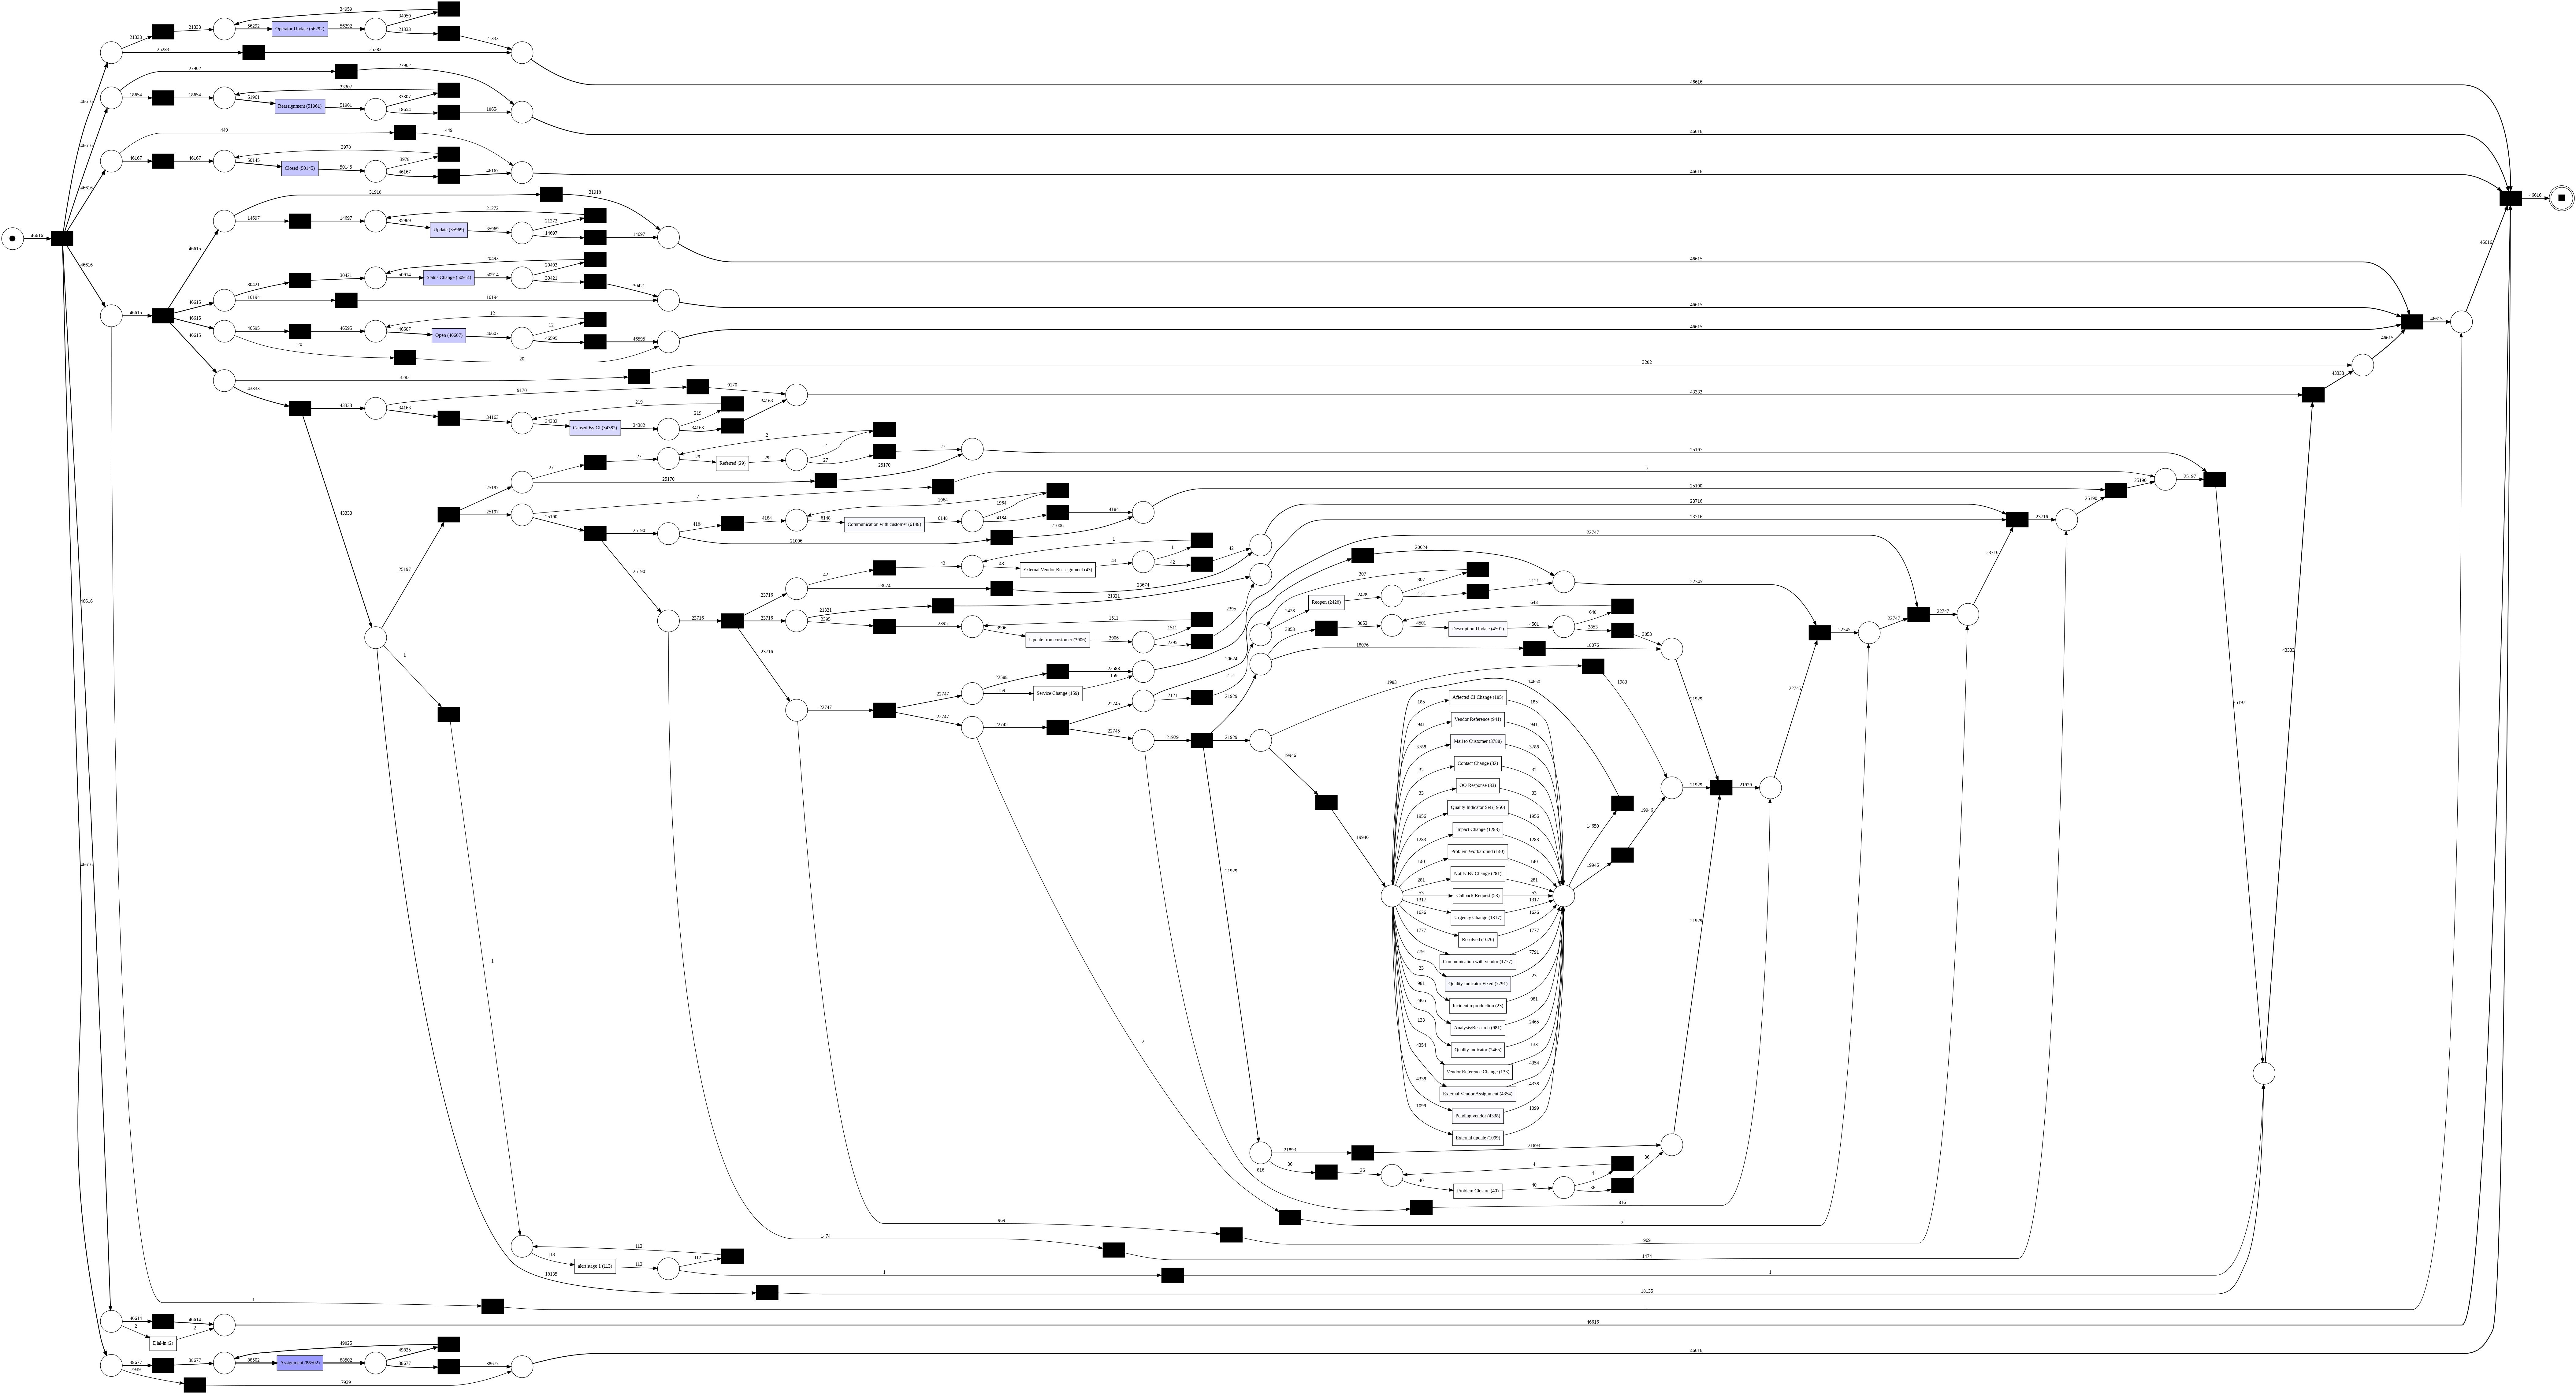

In [ ]:
#inductive miner 
import pm4py
# net, im, fm = inductive_miner.apply(event_log)
net, im, fm = pm4py.discover_petri_net_inductive(event_log)

from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [17]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота: ", simp)

Простота:  0.5811518324607329


In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов: {fitness['average_trace_fitness']}\n")
     

replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов: 1.0



In [ ]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance: {prec}\n")

In [20]:
#heuristics_miner
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

net1, initial_marking1, final_marking1 = pm4py.discover_petri_net_heuristics(event_log)

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [ ]:
gviz1 = pn_visualizer.apply(net1, initial_marking1, final_marking1,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz1)

replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]

In [23]:

simplicity1 = simplicity_evaluator.apply(net1)
print(f"Простота равна: {simplicity1}\n")

fitness1 = replay_fitness_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1, 
    variant=replay_fitness_evaluator.Variants.TOKEN_BASED,
)
print(f"Пригодность воспроизведения, используя метод на основе токенов, равна {fitness1}\n")

prec1 = precision_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1, 
    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,
)
print(f"\nТочность с помощью метода ETConformance равна {prec1}\n")

gen1 = generalization_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1,
)
print(f"\nОбобщение равно {gen1}\n")
     

gen1 = generalization_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1,
)
print(f"\nОбобщение равно {gen1}\n")

Простота равна: 0.38292011019283745



replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]

Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 90.50111549682512, 'average_trace_fitness': 0.9946302766133315, 'log_fitness': 0.9953333109982061, 'percentage_of_fitting_traces': 90.50111549682512}



replaying log with TBR, completed variants ::   0%|          | 0/248024 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.36001743487313165



replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]


Обобщение равно 0.8298023849656501



replaying log with TBR, completed variants ::   0%|          | 0/31725 [00:00<?, ?it/s]


Обобщение равно 0.8298023849656501

